In [2]:
import numpy as np

import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns

import scipy.signal as signal
from scipy.fft import fft

sns.set_theme(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

In [3]:
def fill_trailing_zeros_with_max(arr):
    result = arr.copy()
    for i, row in enumerate(result):
        max_val = np.max(row)
        
        # Find indices of non-zero elements
        nonzero_indices = np.nonzero(row)[0]
        
        if len(nonzero_indices) > 0:
            # Get the index after the last non-zero element
            last_nonzero_idx = nonzero_indices[-1]
            # Fill trailing zeros
            result[i, last_nonzero_idx + 1:] = max_val
    
    return result


def apply_padding(array, padding_length, position="left", paddign_value=0):
    padding_base = np.ones((array.shape[0], padding_length))

    if type(paddign_value) is not int and type(paddign_value) is not float: 
        if len(paddign_value) != array.shape[0]:
            raise ValueError("Padding value must match the number of columns in the array.")
        else:
            padding = (padding_base.T * paddign_value).T
    else:
        padding = padding_base * paddign_value

    if position == "left":
        return np.concatenate((padding, array), axis=1)
    elif position == "right":
        return np.concatenate((array, padding), axis=1)
    elif position == "both":
        return np.concatenate((padding, array, padding), axis=1)
    else:
        raise ValueError("Position must be 'left', 'right', or 'both'.")

In [4]:
# open the file with energy depositions
max_len = 1600
n_signals = 5

energy_depositions = np.zeros((n_signals, max_len))

dict_signals = {}

with open("signals_gesim.txt", "r") as f:
    for line in f:
        kay = str(line.strip()[0:8])
        val = line.strip()[11:-1]
        dict_signals[kay] = val

for idx, kay in enumerate(dict_signals.keys()):
    tmp = dict_signals[kay]
    tmp = tmp.replace(" ", "")
    tmp = tmp.replace("eV", "")
    tmp = tmp.split(",")
    for i in range(len(tmp)):
        energy_depositions[idx, i] = float(tmp[i])


# extend the max value of the energy deposition in the original array
energy_depositions_tailed = fill_trailing_zeros_with_max(energy_depositions)

# apply padding at the beginning of the array (baseline)
padding_length_baseline = int(22400*0.2)
energy_depositions_padded = apply_padding(energy_depositions_tailed, padding_length_baseline, position="left", paddign_value=0)    # baseline

# applay padding at the end of the array (tail)
max_energy = []
for i in range(n_signals):
    max_energy.append(np.max(energy_depositions_padded[i]))
tails = np.array(max_energy) 
padding_length_tail = int(22400*0.8)
energy_depositions_padded = apply_padding(energy_depositions_padded, padding_length_tail, position="right", paddign_value=tails) # tail


In [5]:
q = 1.6e-19
W = 1
R = 10000e9

current = np.gradient(energy_depositions_padded, axis=1)/W * q  # in A
voltage = current * R

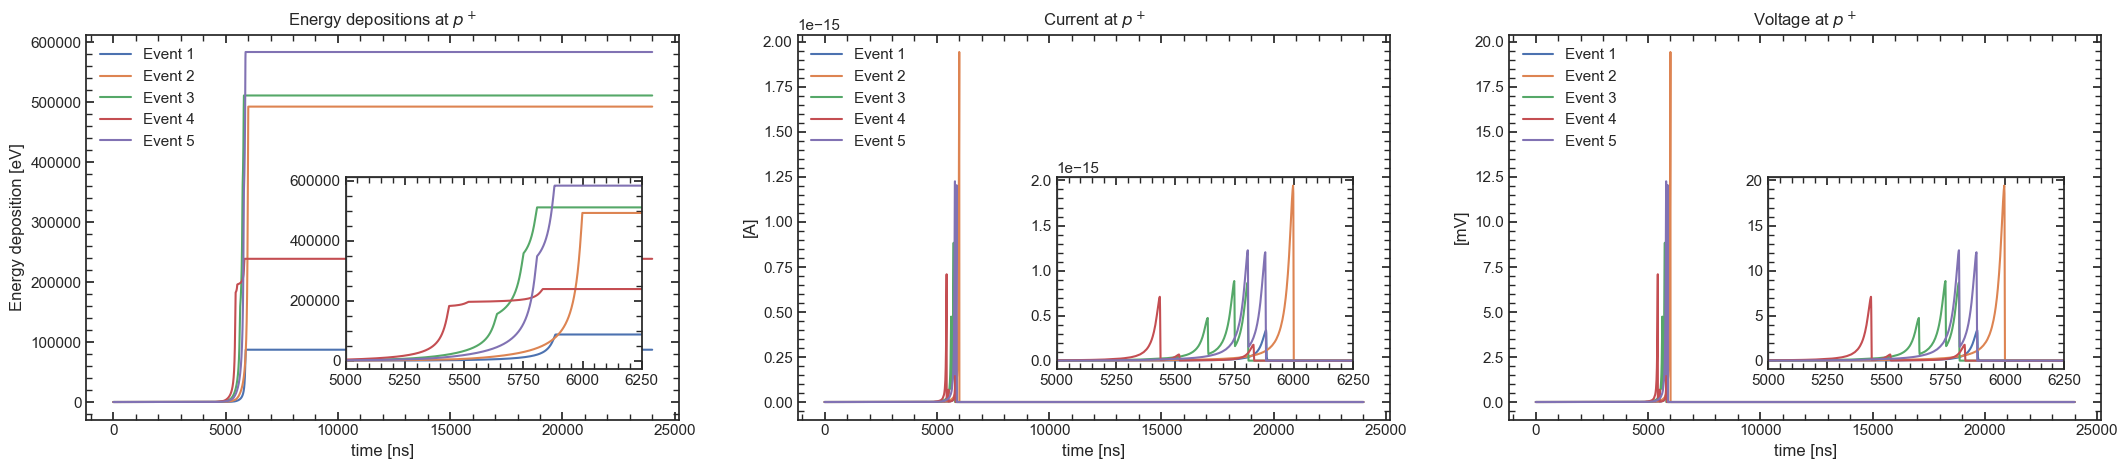

In [6]:
plt.figure(figsize=(26, 5))  

plt.subplot(1, 3, 1)
plt.title("Energy depositions at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("Energy deposition [eV]")

for i in range(n_signals):
    plt.plot(energy_depositions_padded[i], label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.35, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(energy_depositions_padded[i], label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.subplot(1, 3, 2)
plt.title("Current at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("[A]")

for i in range(n_signals):
    plt.plot(current[i], label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.35, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(current[i], label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.subplot(1, 3, 3)
plt.title("Voltage at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("[mV]")

for i in range(n_signals):
    plt.plot(voltage[i]*1e3, label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.35, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(voltage[i]*1e3, label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

-------

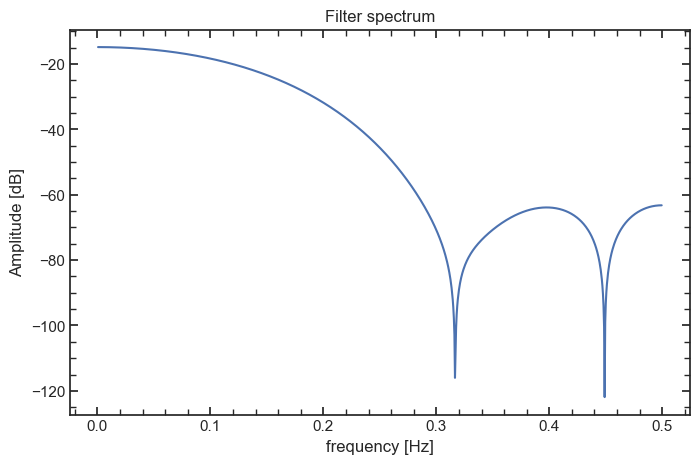

In [7]:
def spectrum(wf,points=int(1000),fs=1):
    """
    Computes the frequency spectrum of a waveform.
    
    Args:
        wf (array): waveform
        points (int): number of points in the psd
        fs (int): sampling frequency
        
    Returns:
        array: frequency
        array: amplitude
        array: phase
    """
    spect = fft(wf,n=2*(points-1),axis=0)
    amp = np.abs(spect/fs/len(wf))
    amp = amp[:int(len(spect)/2+1)]
    amp[1:] = 2*amp[1:]
    phase = np.angle(spect[:int(len(spect)/2+1)])
    freq=np.arange(0,fs/2,fs/2/len(amp))
    return freq,amp,phase

f_h = 15e6 # Hz
f_s = 62.5e6 # Hz

w_h = 2 * np.pi * f_h
w_s = 2 * np.pi * f_s

low_len = 11 # Length of the FIR filter
f_cut = f_h/f_s # Relative Cut frequency for the filter


filter = signal.firwin(numtaps=low_len, cutoff=f_cut, window='hamming')
freq, amp, __ = spectrum(filter, points=1000)

plt.figure(figsize=(8, 5))
plt.title("Filter spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.plot(freq[1:], 20*np.log10(amp[1:]), label="Filter response");


In [8]:
def cc4(detector_signal, dt, units="ADC", add_noise=True, freq_response=True, f_h=15e6, calibration_applied=True):

    ADC_to_V = 0.13/(20e3)
    V_to_ADC = 1/ADC_to_V
    ADC_bias = 15000

    R_f = 1e9
    C_f = 400e-15
    dc_bias = -3.52

    with open('total_transfer_function_params.pkl', 'rb') as f:
        total_transfer_loaded = pickle.load(f)

    with open('calibration_curve_params.pkl', 'rb') as f:
        calibration_curve_loaded = pickle.load(f)

    def integrate_signal(R_f, C_f, input_signal, dt, decay=True):
            tau = R_f * C_f             
            offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
            output_signal = np.zeros_like(input_signal)
            effective_signal = input_signal - offset  

            if decay:
                decay_factor = np.exp(-dt /tau)
            else: decay_factor = 1

            for i in range(1, len(input_signal)):
                input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / (2 * C_f)
                output_signal[i] = output_signal[i-1] * decay_factor + input_contribution
            
            return -output_signal

    if freq_response:
        f_s = 62.5e6 

        low_len = 11 
        f_cut = f_h/f_s 

        filter = signal.firwin(numtaps=low_len, cutoff=f_cut, window='hamming')

    waveforms = np.zeros(detector_signal.shape)

    for i in range(detector_signal.shape[0]):
        input_signal = detector_signal[i,:] + dc_bias
        output_csa = total_transfer_loaded(input_signal)
        integrated_signal = integrate_signal(R_f, C_f, output_csa, dt, decay=True)
        if calibration_applied:
            conversion = calibration_curve_loaded(integrated_signal)
            waveforms[i,:] = (np.array([s*c for s,c in zip(integrated_signal, conversion)]))
        else:
            waveforms[i,:] = integrated_signal

        if add_noise:
            sigma = 0.0002
            noise = np.random.normal(0, sigma, detector_signal.shape[1])
            waveforms[i,:] += noise

        if freq_response:
            waveforms[i,:] = np.convolve(waveforms[i,:], filter)[:-low_len+1] 

    if units == "ADC":
        return (waveforms * V_to_ADC) + ADC_bias    
    elif units == "V":
        return waveforms 
    else:
        raise ValueError("Units must be 'ADC' or 'V'.")


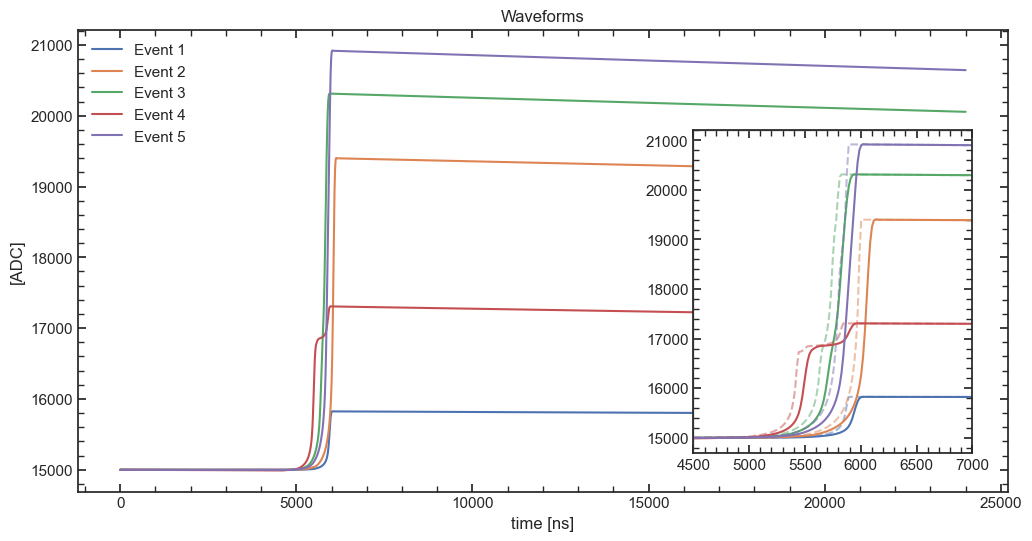

In [22]:
signal_sampled = voltage[:, ::16]
time = np.linspace(0, (max_len + 22400)*1e-9, 1500) # ns
dt = time[1] - time[0]


waveforms = cc4(signal_sampled, dt, units="ADC", add_noise=False, freq_response=True)
waveforms_no_filter = cc4(signal_sampled, dt, units="ADC", add_noise=False, freq_response=False)


plt.figure(figsize=(12, 6))  
plt.title("Waveforms")
plt.xlabel("time [ns]")
plt.ylabel("[ADC]")

for i in range(n_signals):
    plt.plot(time*1e9, waveforms[i], label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="30%", 
                    height="70%", 
                    bbox_to_anchor=(-0.03, -0.2, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    line1 = axins.plot(time*1e9, waveforms[i])
    color = line1[0].get_color()
    axins.plot(time*1e9, waveforms_no_filter[i], ls ='--', color=color, alpha=0.5)

axins.set_xlim(4500, 7000)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()


----------

In [23]:
waveforms = cc4(signal_sampled, dt, units="V", add_noise=False, freq_response=False)


output_df = pd.DataFrame(waveforms.T, columns=[f"event_{i+1}" for i in range(n_signals)])
output_df['time'] = time

output_df



,event_1,event_2,event_3,event_4,event_5,time
0,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00
1,-8.883380e-09,-2.665014e-08,-1.332507e-07,-2.487346e-07,-7.995042e-08,1.601067e-08
2,-1.776640e-08,-5.329921e-08,-2.664961e-07,-4.974593e-07,-1.598976e-07,3.202135e-08
3,-2.664907e-08,-7.994722e-08,-3.997361e-07,-7.461741e-07,-2.398417e-07,4.803202e-08
4,-3.553139e-08,-1.065942e-07,-5.329708e-07,-9.948788e-07,-3.197825e-07,6.404270e-08
...,...,...,...,...,...,...
1495,5.112273e-03,2.731365e-02,3.285621e-02,1.405868e-02,3.668317e-02,2.393596e-05
1496,5.112059e-03,2.731253e-02,3.285477e-02,1.405787e-02,3.668162e-02,2.395197e-05
1497,5.111846e-03,2.731141e-02,3.285332e-02,1.405706e-02,3.668008e-02,2.396798e-05
1498,5.111632e-03,2.731030e-02,3.285187e-02,1.405625e-02,3.667853e-02,2.398399e-05


In [24]:
output_df.to_csv("simulated_waveforms.csv", index=False)